In [211]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
from astropy.io import ascii

In [2]:
gw170817 = ascii.read('http://www.tauceti.caltech.edu/kunal/gw170817/gw170817_afterglow_data_full.txt')
data = gw170817.to_pandas()
data

,DateUT,T,Telescope,Freq,FluxD,FluxDErr
0,2017-Aug-18.10,0.57,VLA,9.700000e+09,<144,NaN
1,2017-Aug-18.1,0.60,Swift,2.410000e+17,<7.8e-3,NaN
2,2017-Aug-18.21,0.68,ATCA,8.500000e+09,<120,NaN
3,2017-Aug-18.21,0.68,ATCA,1.050000e+10,<150,NaN
4,2017-Aug-18.2,0.70,NuSTAR,1.200000e+18,<7.3e-4,NaN
...,...,...,...,...,...,...
210,2021-Apr-08,1330.00,ATCA,5.500000e+09,<44,NaN
211,2021-Apr-08,1330.00,ATCA,9.000000e+09,<31,NaN
212,2020-Dec-09--2021-Jan-27,1231.00,Chandra,2.410000e+17,1.70e-4,0.000047
213,2020-Sep-19--2021-Feb-08,1228.00,VLA,3.000000e+09,2.86e0,0.990000


In [3]:
mask = np.where(data['Telescope'] == 'VLA')[0]
mask1 = np.where(data['Freq'] == 3.000000e+09)[0]
mask2 = np.intersect1d(mask, mask1)

Chandra_mask = np.where(data['Telescope'] == 'Chandra')[0]
Chandra_mask1 = np.where(data['Freq'] == 2.410000e+17)[0]
Chandra_mask2 = np.intersect1d(Chandra_mask, Chandra_mask1)

In [45]:
VLA_flux = np.array(data['FluxD'][mask2])
for index in range(len(VLA_flux)):
    if VLA_flux[index][0] == '<':
        VLA_flux[index] = VLA_flux[index][1:]
    VLA_flux[index] = float(VLA_flux[index])
VLA_time = np.array(data['T'][mask2])

Chandra_data= np.array(data['FluxD'][Chandra_mask2])
for index in range(len(Chandra_data)):
    if Chandra_data[index][0] == '<':
        Chandra_data[index] = Chandra_data[index][1:]
    Chandra_data[index] = float(Chandra_data[index])
Chandra_time = np.array(data['T'][Chandra_mask2])

Chandra_flux = np.array(Chandra_data)*pow(2.410000e+17/3.000000e+09,0.584)
print(VLA_flux, Chandra_flux)

[32.0 19.0 18.7 15.1 14.5 22.5 25.6 34.0 44.0 48.0 61.0 70.0 96.2 97.3
 75.9 60.5 64.7 43.2 40.3 34.8 36.3 31.2 14.8 4.9 2.86] [9.510141441656788 18.524101590705396 21.12905337689834 87.24521061693835
 90.5530859009929 47.55070720828394 29.440090028085358 10.874639996329282
 9.05530859009929 5.375297336588619 7.029234978615887]


In [595]:
time = (np.append(VLA_time,Chandra_time))
flux = np.append(VLA_flux,Chandra_flux)
t_data = (time)
log_t_data = np.log(t_data)

In [596]:
max_flux_index = np.where(flux == max(flux))[0]
peak_time = time[max_flux_index]
alpha1_est = math.atan(flux[0] - flux[max_flux_index])/(time[0] - time[max_flux_index]).item()
alpha2_est = math.atan(flux[-1] - flux[max_flux_index])/(time[-1] - time[max_flux_index]).item()


/var/folders/90/gzrv1_253_sg6d5md2p4dc0w0000gn/T/ipykernel_76231/3198317906.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha1_est = math.atan(flux[0] - flux[max_flux_index])/(time[0] - time[max_flux_index]).item()
/var/folders/90/gzrv1_253_sg6d5md2p4dc0w0000gn/T/ipykernel_76231/3198317906.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  alpha2_est = math.atan(flux[-1] - flux[max_flux_index])/(time[-1] - time[max_flux_index]).item()


In [597]:
def smooth_broken_power_law(t, nu, beta, Fp, tp, s, alpha1, alpha2):
    return 2**(1/s) * (nu/3.0)**beta * Fp * ((t/tp)**(-s*alpha1) + (t/tp)**(-s*alpha2))**(-1/s)


In [598]:
def likelihood(theta, t, nu, F_obs, sigma):
    beta, Fp, tp, s, alpha1, alpha2 = theta
    F_model = smooth_broken_power_law(t, nu, beta, Fp, tp, s, alpha1, alpha2)
    return (-0.5 * np.sum(((F_obs - F_model) / sigma)**2 + np.log(2 * np.pi * sigma**2)))


In [630]:
def prior(theta):
    beta, Fp, tp, s, alpha1, alpha2 = theta
    if 0 < Fp <150 and 0 < tp < 8 and 0.01 < s < 10 and 0 < alpha1 < 3.14/2 and -3.14/2 < alpha2 < 0:
        return 0  # Uniform prior
    else:
        return -np.inf

In [631]:
# Define the log-posterior function
def posterior(theta, t, nu, F_obs, sigma):
    lp = prior(theta)
    return math.exp(lp + likelihood(theta, t, nu, F_obs, sigma))
               

In [703]:
def metropolis_hastings(log_posterior, initial_theta, iterations, step_size, t, nu, F_obs, sigma):
    theta = initial_theta
    samples = []
    posterior_current = log_posterior(theta, t, nu, F_obs, sigma)
    
    for i in range(iterations):
        theta_proposal = theta + np.random.normal(0, step_size, size=theta.shape)
        posterior_proposal = posterior(theta_proposal, t, nu, F_obs, sigma)
    
        if posterior_current == 0:
            output_div = 1
        else :
            output_div = posterior_proposal / posterior_current
        if np.random.rand() < output_div:
            theta = theta_proposal
            posterior_current = posterior_proposal
        
        samples.append(theta)
    
    return np.array(samples)

In [774]:
t_data = time
nu_data = 3  # Constant observing frequency of 3 GHz
F_data = flux
sigma_data = 0.5 * np.ones_like(t_data)

# Run the MCMC sampler
initial_theta = np.array([-0.584, max(flux), peak_time.item(), 1, alpha1_est, alpha2_est])
initial_theta = np.array([-0.584, 97.38445406432662, 162.86128223947676, 2.224600723436645, 1.480073585872019, -2.021640332198968])
print('starting with estimates ', initial_theta)
iterations = 50000
step_size = np.array([0.001, 1, 0.002, 0.02, 0.001, 0.001])
samples = metropolis_hastings(posterior, initial_theta, iterations, step_size, t_data, nu_data, F_data, sigma_data)

starting with estimates  [ -0.584       97.38445406 162.86128224   2.22460072   1.48007359
  -2.02164033]


In [775]:
beta_samples = samples[:, 0]
Fp_samples = samples[:, 1]
tp_samples = samples[:, 2] 
s_samples = samples[:, 3]
alpha1_samples = samples[:, 4]
alpha2_samples = samples[:, 5]

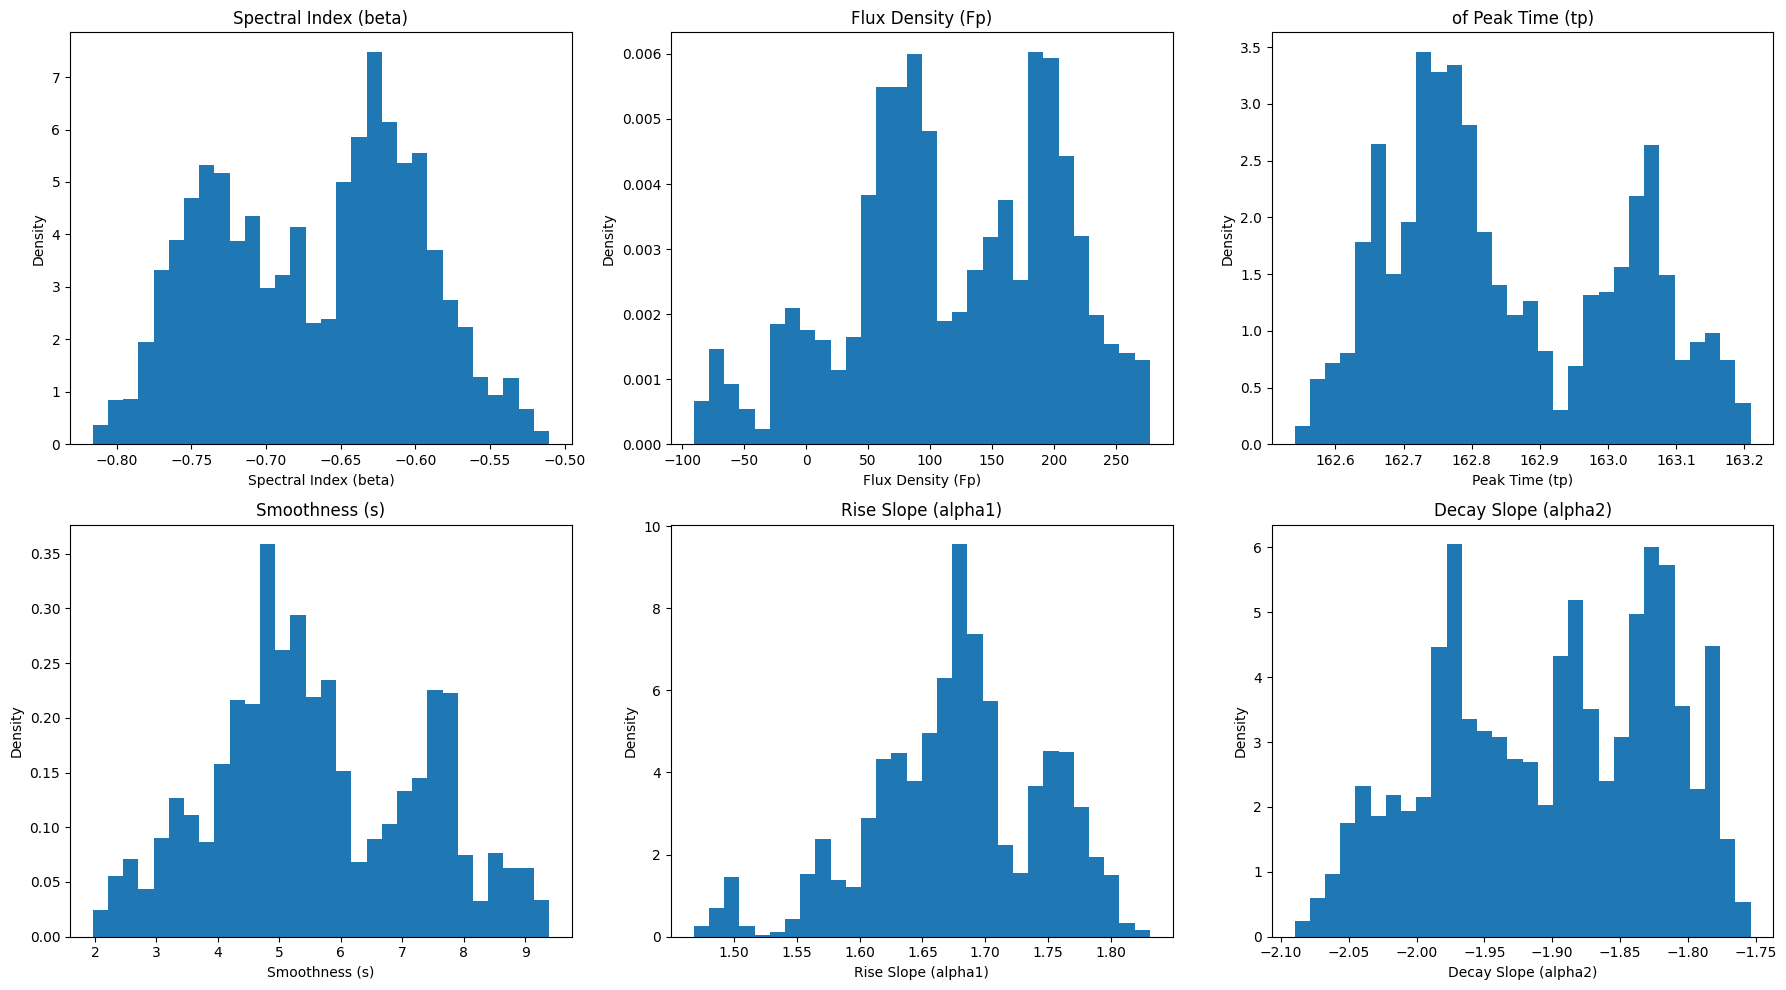

In [776]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes[0, 0].hist(beta_samples, bins=30, density=True)
axes[0, 0].set_xlabel('Spectral Index (beta)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Spectral Index (beta)')

axes[0, 1].hist(Fp_samples, bins=30, density=True)
axes[0, 1].set_xlabel('Flux Density (Fp)')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Flux Density (Fp)')

axes[0, 2].hist(tp_samples, bins=30, density=True)
axes[0, 2].set_xlabel('Peak Time (tp)')
axes[0, 2].set_ylabel('Density')
axes[0, 2].set_title('of Peak Time (tp)')

axes[1, 0].hist(s_samples, bins=30, density=True)
axes[1, 0].set_xlabel('Smoothness (s)')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Smoothness (s)')

axes[1, 1].hist(alpha1_samples, bins=30, density=True)
axes[1, 1].set_xlabel('Rise Slope (alpha1)')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Rise Slope (alpha1)')

axes[1, 2].hist(alpha2_samples, bins=30, density=True)
axes[1, 2].set_xlabel('Decay Slope (alpha2)')
axes[1, 2].set_ylabel('Density')
axes[1, 2].set_title('Decay Slope (alpha2)')

plt.tight_layout()
plt.show()

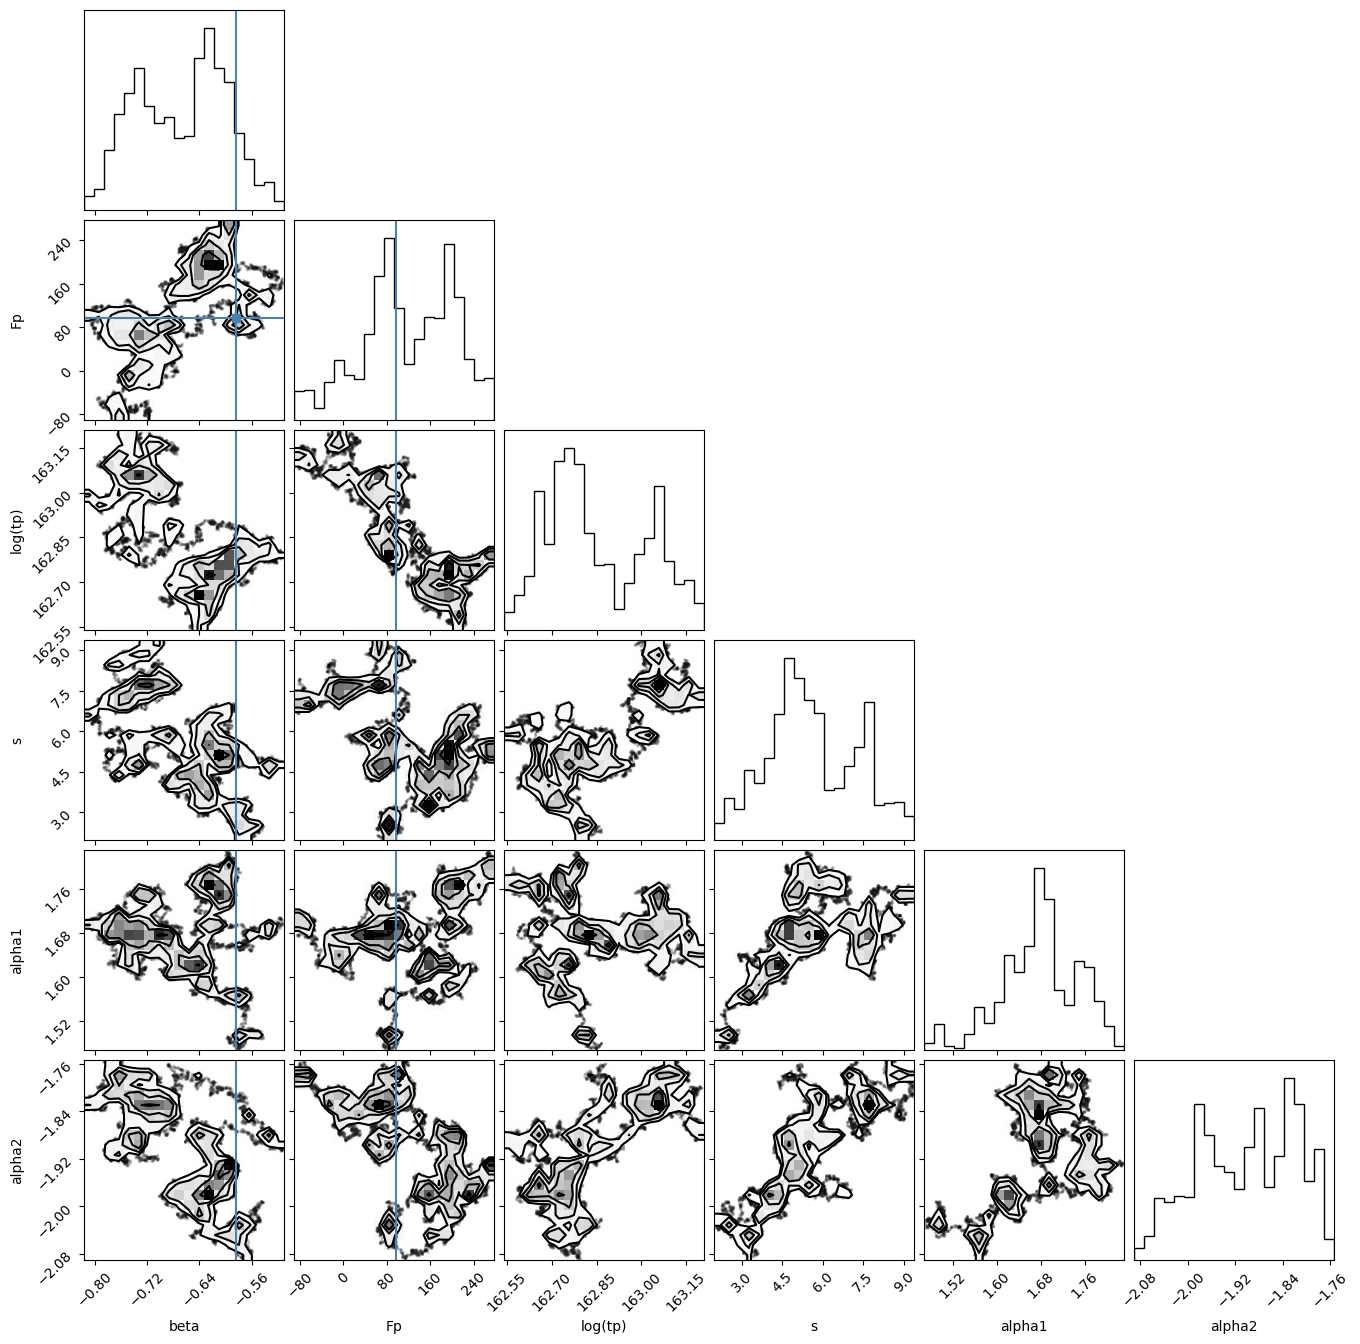

In [777]:
import corner

fig = corner.corner(samples, labels=labels, truths=[beta_mcmc, Fp_mcmc, log_tp_mcmc, s_mcmc, alpha1_mcmc, alpha2_mcmc])
plt.show()

params:
beta -0.6668521778260433 F_p 117.64609749125337 t_p 162.85214734728333 s 5.598125082942775 alpha1 1.677358594232929 alpha2 -1.9013552953228732


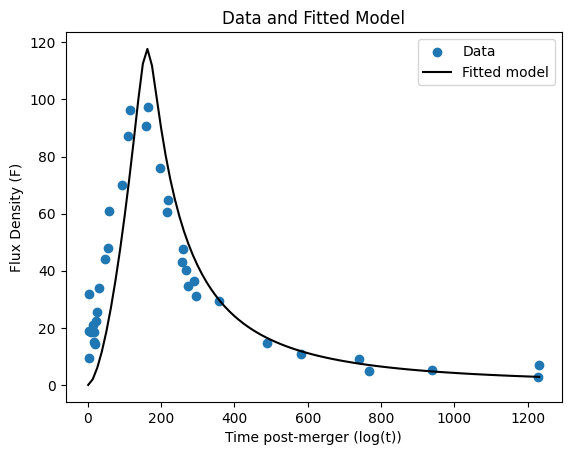

In [779]:
# Plot the data and the fitted model
plt.scatter(t_data, F_data, label='Data')
t_fit = np.linspace(1, max(t_data), 100)
print('params:')
print('beta', np.mean(beta_samples),'F_p', np.mean(Fp_samples),'t_p', np.mean(tp_samples),'s', np.mean(s_samples),'alpha1', np.mean(alpha1_samples),'alpha2', np.mean(alpha2_samples))
F_fit = smooth_broken_power_law(t_fit, nu_data, np.mean(beta_samples), np.mean(Fp_samples), np.mean(tp_samples), np.mean(s_samples), np.mean(alpha1_samples), np.mean(alpha2_samples))
plt.plot(t_fit, F_fit, color='k', label='Fitted model')
#F_initial = smooth_broken_power_law(t_fit, nu_data,-0.584, max(flux), peak_time.item(), 2.2, alpha1_est, alpha2_est)
#plt.plot(t_fit, F_initial, label='initial model')

plt.xlabel('Time post-merger (log(t))')
plt.ylabel('Flux Density (F)')
#plt.xscale('log')
plt.legend()
plt.title('Data and Fitted Model')
plt.show()

params:
beta -0.6668521778260433 F_p 117.64609749125337 t_p 162.85214734728333 s 5.598125082942775 alpha1 1.677358594232929 alpha2 -1.9013552953228732


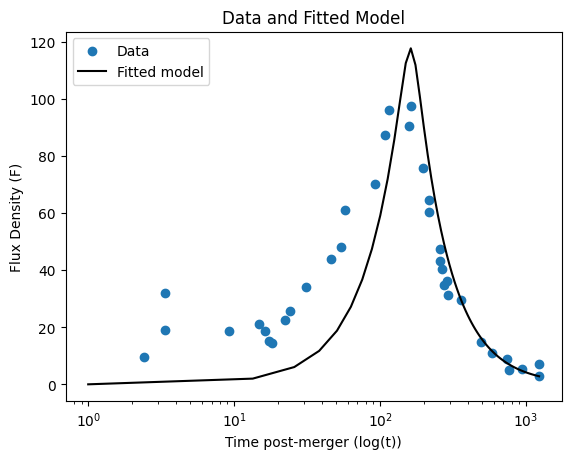

In [780]:
#t_data = np.log(t_data)

plt.scatter(t_data, F_data, label='Data')
t_fit = np.linspace(1, max(t_data), 100)
print('params:')
print('beta', np.mean(beta_samples),'F_p', np.mean(Fp_samples),'t_p', np.mean(tp_samples),'s', np.mean(s_samples),'alpha1', np.mean(alpha1_samples),'alpha2', np.mean(alpha2_samples))
F_fit = smooth_broken_power_law(t_fit, nu_data, np.mean(beta_samples), np.mean(Fp_samples), np.mean(tp_samples), np.mean(s_samples), np.mean(alpha1_samples), np.mean(alpha2_samples))
plt.plot(t_fit, F_fit, color='k', label='Fitted model')
#F_initial = smooth_broken_power_law(t_fit, nu_data,-0.584, max(flux), peak_time.item(), 0.3, alpha1_est.item(), alpha2_est.item())
#plt.plot(t_fit, F_initial, label='initial model')

plt.xlabel('Time post-merger (log(t))')
plt.ylabel('Flux Density (F)')
plt.xscale('log')
plt.legend()
plt.title('Data and Fitted Model')
plt.show()